# NLU Demo using RASA
## Goal -- Determine script content starting from search term
The idea is to analzye the intro of a video script and determine what creators say and when.  In order to completely analyze the text, we'll make a sliding window and run it across the script.
## Method 
 1. Retrieve video scripts using simple youtube search
 2. Re-window this data so that each subsequent sequence of words are categorized
 3. Pass the texts to RASA to determine the language content (see data/nlu.yml for training data)
 4. Make some analysis and figures
 
## RASA
RASA encapsulates a deep neural network that is trained to return the 'intent' of the input phrase.  The allowed intents must be trained and can be found in data/nlu.yml.  The output is a score from 0-1 for each possible intent, with all results summing to 1. 

## Notes
A few utility functions are used and can be found in youtube.py

In [1]:
import pandas as pd
import json
import requests
import cycler
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# utility functions for youtube
import youtube


## Global variables
Change SEARCH_STRING to find different videos

In [2]:
SEARCH_STRING = 'how to improve your coding skills' # this is the video search (easier than finding and pasting the URL)
RASA_API = 'http://localhost:5005/model/parse' # Location of RASA API (port mapped in docker-compose.yml)
WINDOW_SIZE = 8 # Number of words in a window
TIME_CUTOFF = 30 # only analyze scripts up to this time (seconds)

## Step 1 - Get videos from youtube search and get their captions.  May take a few seconds
We will only use the first video in the list for this demo

In [3]:
search_results = youtube.search_for_videos(SEARCH_STRING)
videos = [v['id'] for v in search_results['videos']]

res = youtube.retrieve_captions(videos)

# we will use the first entry for this demo 
video = list(res.keys())[0]
captions = res[video]

# create a dataframe
df = pd.DataFrame(captions)

# ensure numerical values
df['start'] = df['start'].astype(float)
df['duration'] = df['duration'].astype(float)

## Break apart script sections into individual words
Scripts come with a variable number of words per line and we want to control this.  Start by breaking it down word-by-word.  Interpolate the start and end time for future use.

In [4]:
def dewindow_and_interpolate_times(row):
    """ Interpolate times for each word in texts"""

    #  split the text into a list
    words = row.text.split(' ')

    # determine the average interval
    # between texts 
    # this is not completely accurate
    # but doens't matter on a word-by-word level
    interval = row.duration/len(words)

    # generate new starts and ends based on the interval and number of words
    starts = [row.start + x*interval for x in range(0, len(words))]
    ends = [s + interval for s in starts]

    row['start'] = starts
    row['end'] = ends
    row['text'] = words

    return row

df = df.apply(dewindow_and_interpolate_times, axis=1)

# select only the needed columns
df = df[['start', 'end', 'text']]
# now every entry in the dataframe is an array
# with each row having the same length arrays across
# all columns.
# explode them into rows
# I always wanted to explode pandas dataframes
df = df.apply(pd.Series.explode).reset_index()

## inspect the word-by-word dataframe

In [5]:
print (df)

      index     start       end         text
0         0      0.09  0.255714            -
1         0  0.255714  0.421429           In
2         0  0.421429  0.587143  today&#39;s
3         0  0.587143  0.752857       video,
4         0  0.752857  0.918571            I
...     ...       ...       ...          ...
1403    159    393.87  394.1426          and
1404    159  394.1426  394.4152     I&#39;ll
1405    159  394.4152  394.6878          see
1406    159  394.6878  394.9604          you
1407    159  394.9604   395.233        soon.

[1408 rows x 4 columns]


### Filter to look at the beginning of the script
This will avoid analyzing hours-long vidoes and helps visualization

In [6]:
df = df[df.start <= TIME_CUTOFF]

## Step-2 Windowing
Now do some data manipulation to add new windows based on the window size
Since the same text will contribute to multiple windows, we will do a cross join
### Note 
the cross join is a convenient work-around for pandas dataframes not natively supporting joins on inequalities.  This method does not scale to very large sets, but is more elegant for this demo

In [7]:
# we want a new window at every word
df['window_start'] = df.index
df['window_end'] = df['window_start'] + WINDOW_SIZE
# do not allow the end of the window to exceed the number of rows
nrows = df.shape[0]
df.loc[df.window_end >= nrows, 'window_end'] = nrows - 1

In [8]:
# make a dataframe from the list of window numbers
_window_number = list(range(0, nrows))
window_df = pd.DataFrame(_window_number, columns=['window_number'])

In [9]:
# Add a dummy index to cross join
window_df['dummy'] = 1
df['dummy'] = 1
df_cross = pd.merge(window_df, df, on='dummy')
# keep only the rows we want
df_cross = df_cross[((df_cross.window_number >= df_cross.window_start) & (df_cross.window_number < df_cross.window_end))]

## Aggregate on windows

In [10]:
windowed = df_cross.groupby('window_number').agg({'start': min, 'end' : max, 'text' : ' '.join})
#inspect the result
print(windowed)

                   start        end  \
window_number                         
0               0.090000   0.255714   
1               0.090000   0.421429   
2               0.090000   0.587143   
3               0.090000   0.752857   
4               0.090000   0.918571   
...                  ...        ...   
78             26.922000  28.890000   
79             27.191000  29.128333   
80             27.460000  29.366667   
81             27.698333  29.605000   
82             27.936667  29.843333   

                                                       text  
window_number                                                
0                                                         -  
1                                                      - In  
2                                          - In today&#39;s  
3                                   - In today&#39;s video,  
4                                 - In today&#39;s video, I  
...                                                     ..

## Step 3 - Determine scores for each set of texts
On a row-by-row basis, query the rasa API for the scores and append them to the dataset

In [11]:
def get_scores(row):
    
    # format the query
    data = {'text' : row['text']}
    res = requests.post(RASA_API, data = json.dumps(data)).json()

    # get the results from all intents
    for intent in res['intent_ranking']:
        name = intent['name']
        # ignore this default intent
        if name == 'nlu_fallback':
            continue
        # get the numerical confidence score
        conf = intent['confidence']
        row[name] = conf 
        
    return row

scored = windowed.apply(get_scores, axis=1)
#get a list of added columns from the results (so that changes to the training intents are automatically picked up)
score_columns = list(set(scored) - set(windowed.columns)) 
scored.reset_index(inplace=True)
# inspect the results
print (scored)

    window_number     authority        end       goodbye         greet  \
0               0  1.534692e-04   0.255714  5.408623e-03  5.535322e-01   
1               1  2.445087e-03   0.421429  7.245662e-04  2.065226e-03   
2               2  7.614135e-07   0.587143  8.395270e-07  6.124571e-08   
3               3  1.581082e-07   0.752857  2.147282e-07  2.001535e-08   
4               4  9.630786e-07   0.918571  2.488144e-07  3.823801e-08   
..            ...           ...        ...           ...           ...   
78             78  4.749263e-02  28.890000  3.195477e-04  1.068140e-01   
79             79  2.872732e-03  29.128333  9.366404e-05  1.269734e-02   
80             80  2.220475e-02  29.366667  5.517132e-03  2.428630e-01   
81             81  1.532782e-01  29.605000  6.661428e-03  6.363582e-01   
82             82  1.151012e-03  29.843333  3.689452e-04  1.787706e-04   

    introduce   sponsor      start     subscribe     summarize     tease  \
0    0.420934  0.000545   0.090000 

## Step 4 - some basic results

### plot all scores as a function of time

<AxesSubplot:xlabel='start'>

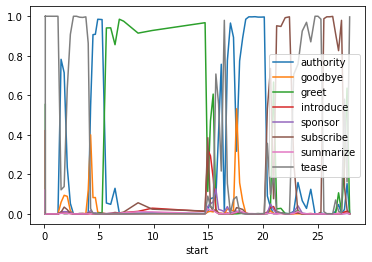

In [12]:
scored_plt = scored.set_index('start')
scored_plt.drop(columns=['window_number', 'end'], inplace=True)
scored_plt.plot()

### Determine the intent that gives the maximum score as a function of time
We want to get the maximum value and the intent (argmax)

In [13]:
scored_tomax = scored.set_index(['start', 'end'])

# Get the column name that corresponds to the max
df_argmax = scored_tomax[score_columns].idxmax(axis=1)
# Get the max values
df_max = scored_tomax[score_columns].max(axis=1)

# combine into a single dataframe
df_comb = pd.concat([df_argmax, df_max], axis=1)
df_comb.columns=['type', 'score']

df_comb.reset_index(inplace=True)

#inspect the results
print (df_comb)


        start        end       type     score
0    0.090000   0.255714      greet  0.553532
1    0.090000   0.421429      tease  0.790609
2    0.090000   0.587143      tease  0.999981
3    0.090000   0.752857      tease  0.999995
4    0.090000   0.918571      tease  0.999990
..        ...        ...        ...       ...
78  26.922000  28.890000  subscribe  0.826056
79  27.191000  29.128333  subscribe  0.979370
80  27.460000  29.366667      tease  0.580136
81  27.698333  29.605000      greet  0.636358
82  27.936667  29.843333      tease  0.996592

[83 rows x 4 columns]


### Plot the results
First do some work to get the proper framing and colors, then use fill_between to make the figure

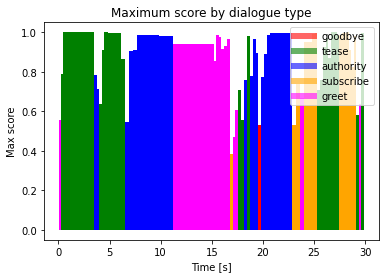

In [14]:
# Use a shift to get a non-overlapping interval
df_comb['prev_end'] = df_comb['end'].shift(1)
df_comb.loc[pd.isnull(df_comb.prev_end), 'prev_end'] = min(df_comb['start'])

# get a color cycler and determine the color for each type.
# this is mainly for convenience so that we cannot exceed the 
# size of our color list, but it can result in duplicate colors
color_cycle = cycler.cycler(color=['red', 'green', 'blue', 'orange', 'magenta', 'cyan', 'lightgreen'])
all_types = list(set(df_comb['type']))
type_colors = {tp : col['color'] for tp, col in zip(all_types, color_cycle)}


_, ax = plt.subplots()

# Fill the figure for each row up to the score value
for ir, row in df_comb.iterrows():
    tp = row['type']
    ax.fill_between([row['prev_end'], row['end']], 0, row['score'], facecolor=type_colors[tp], label=tp)

plt.xlabel('Time [s]')
plt.ylabel('Max score')
plt.title('Maximum score by dialogue type')

# since its a non-standard plot, we need to create 
# the legend manually
custom_lines = []
for tp, col in type_colors.items():
    custom_lines.append(Line2D([0], [0], color=col, lw=6, alpha=0.6))
ax.legend(custom_lines, type_colors.keys())
plt.show()


## We now have an abstracted script for this video, which can be further used for data science and easliy scaled to many videos